In [358]:
# Importing the libraries
import pandas as pd
import numpy as np

from math import nan
from sklearn.utils import resample
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.compose import make_column_transformer
from sklearn.metrics import f1_score
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow import keras
import matplotlib.pyplot as plt

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [291]:
np.random.seed(15)
tf.random.set_seed(15)

In [292]:
# load data and see how it looks like
train = pd.read_csv('train', index_col = 0)
train

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,...,LID_KB,NITR_S,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,LET_IS
1414,60.0,0,0.0,5.0,2.0,1.0,2.0,0.0,6.0,0.0,...,NaN,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0
227,57.0,0,1.0,1.0,2.0,2.0,2.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
280,52.0,1,1.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0
1538,73.0,0,1.0,6.0,3.0,NaN,2.0,0.0,6.0,4.0,...,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
1418,78.0,0,0.0,2.0,2.0,2.0,2.0,0.0,NaN,0.0,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,55.0,1,3.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0
238,73.0,1,1.0,4.0,2.0,2.0,2.0,0.0,NaN,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0
1444,65.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
409,75.0,0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,...,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0


In [293]:
# Check this because when running Onehotencoder has problems. May need to change to integer or stings
# train.dtypes.value_counts()

float64    97
int64       2
dtype: int64

In [294]:
train.isnull().sum()

AGE           6
SEX           0
INF_ANAM      4
STENOK_AN    90
FK_STENOK    62
             ..
GEPAR_S_n    12
ASP_S_n      12
TIKL_S_n     11
TRENT_S_n    11
LET_IS        0
Length: 99, dtype: int64

In [295]:
# check if already dropped the features with high rate (more than 50%) of NaN values, and looks already dropped
newtrain = train.loc[:, (train.isnull().sum(axis=0) < 1700/2)]
newtrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1360 entries, 1414 to 444
Data columns (total 99 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AGE            1354 non-null   float64
 1   SEX            1360 non-null   int64  
 2   INF_ANAM       1356 non-null   float64
 3   STENOK_AN      1270 non-null   float64
 4   FK_STENOK      1298 non-null   float64
 5   IBS_POST       1317 non-null   float64
 6   GB             1353 non-null   float64
 7   SIM_GIPERT     1353 non-null   float64
 8   DLIT_AG        1165 non-null   float64
 9   ZSN_A          1315 non-null   float64
 10  nr_11          1342 non-null   float64
 11  nr_01          1342 non-null   float64
 12  nr_02          1342 non-null   float64
 13  nr_03          1342 non-null   float64
 14  nr_04          1342 non-null   float64
 15  nr_07          1342 non-null   float64
 16  nr_08          1342 non-null   float64
 17  np_01          1346 non-null   float64
 18  np_04 

In [296]:
# Imputation: fill in with median for continuous features 
newtrain.fillna(newtrain[['AGE', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'GB', 'DLIT_AG', 'ZSN_A',
                         'S_AD_ORIT', 'D_AD_ORIT', 'ant_im', 'lat_im', 'inf_im', 'post_im', 'K_BLOOD',
                         'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'L_BLOOD', 'ROE', 'TIME_B_S']].median(), inplace=True)

In [297]:
# Imputation: fill in with mode for categorical features
for column in newtrain[newtrain.columns[~newtrain.columns.isin(['AGE', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'GB', 'DLIT_AG', 'ZSN_A',
                         'S_AD_ORIT', 'D_AD_ORIT', 'ant_im', 'lat_im', 'inf_im', 'post_im', 'K_BLOOD',
                         'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'L_BLOOD', 'ROE', 'TIME_B_S'])]]:
    newtrain[column].fillna(newtrain[column].mode()[0], inplace=True)

In [303]:
# check if successfully fill in
newtrain.isnull().sum()

AGE          0
SEX          0
INF_ANAM     0
STENOK_AN    0
FK_STENOK    0
            ..
GEPAR_S_n    0
ASP_S_n      0
TIKL_S_n     0
TRENT_S_n    0
LET_IS       0
Length: 99, dtype: int64

In [299]:
# newtrain[['INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'GB', 'DLIT_AG', 'ZSN_A', 'ant_im', 'lat_im', 'inf_im', 'post_im',\
#  'TIME_B_S']]=newtrain[['INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'GB', 'DLIT_AG', 'ZSN_A', 'ant_im', 'lat_im', 'inf_im', 'post_im',\
#  'TIME_B_S']].astype(str)

In [300]:
#newtrain.info()

In [301]:
X_train = newtrain.loc[:, newtrain.columns!='LET_IS']
y_train = pd.Series(newtrain['LET_IS'])

In [302]:
X_train

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,...,NOT_NA_KB,LID_KB,NITR_S,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
1414,60.0,0,0.0,5.0,2.0,1.0,2.0,0.0,6.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
227,57.0,0,1.0,1.0,2.0,2.0,2.0,0.0,6.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
280,52.0,1,1.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1538,73.0,0,1.0,6.0,3.0,1.0,2.0,0.0,6.0,4.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1418,78.0,0,0.0,2.0,2.0,2.0,2.0,0.0,3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,55.0,1,3.0,0.0,0.0,2.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
238,73.0,1,1.0,4.0,2.0,2.0,2.0,0.0,3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1444,65.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
409,75.0,0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [305]:
continuous_col=['AGE',
 'S_AD_ORIT',
 'D_AD_ORIT',
 'K_BLOOD',
 'NA_BLOOD',
 'ALT_BLOOD',
 'AST_BLOOD',
 'L_BLOOD',
 'ROE',
 'INF_ANAM',
 'STENOK_AN',
 'FK_STENOK',
 'IBS_POST',
 'GB',
 'DLIT_AG',
 'ZSN_A',
 'ant_im',
 'lat_im',
 'inf_im',
 'post_im',
 'TIME_B_S']

binary_col = list(X_train.drop(continuous_col, axis=1).columns)

In [306]:
scalor=MinMaxScaler()

In [307]:
# check continuous columns
X_train[continuous_col]

,AGE,S_AD_ORIT,D_AD_ORIT,K_BLOOD,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,INF_ANAM,...,FK_STENOK,IBS_POST,GB,DLIT_AG,ZSN_A,ant_im,lat_im,inf_im,post_im,TIME_B_S
1414,60.0,190.0,100.0,4.1,130.0,0.38,0.22,10.8,9.0,0.0,...,2.0,1.0,2.0,6.0,0.0,0.0,0.0,3.0,1.0,7.0
227,57.0,120.0,80.0,3.5,130.0,0.45,0.15,5.1,10.0,1.0,...,2.0,2.0,2.0,6.0,0.0,0.0,0.0,3.0,0.0,3.0
280,52.0,130.0,80.0,4.4,144.0,0.61,0.30,6.9,13.0,1.0,...,0.0,2.0,2.0,2.0,0.0,0.0,0.0,3.0,0.0,9.0
1538,73.0,130.0,100.0,5.4,130.0,0.75,0.15,10.2,18.0,1.0,...,3.0,1.0,2.0,6.0,4.0,1.0,1.0,0.0,0.0,3.0
1418,78.0,130.0,80.0,7.3,153.0,0.22,0.15,4.9,53.0,0.0,...,2.0,2.0,2.0,3.0,0.0,1.0,1.0,0.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,55.0,140.0,90.0,4.1,136.0,0.38,0.30,6.9,22.0,3.0,...,0.0,2.0,2.0,1.0,0.0,3.0,1.0,0.0,0.0,7.0
238,73.0,110.0,70.0,4.1,136.0,0.45,0.40,5.0,3.0,1.0,...,2.0,2.0,2.0,3.0,0.0,0.0,0.0,2.0,0.0,2.0
1444,65.0,100.0,60.0,4.4,132.0,0.38,0.22,8.5,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,9.0
409,75.0,220.0,120.0,3.5,136.0,0.38,0.26,5.9,18.0,0.0,...,0.0,2.0,2.0,2.0,0.0,4.0,1.0,4.0,0.0,3.0


In [308]:
continue_df=pd.DataFrame(scalor.fit_transform(X_train[continuous_col].to_numpy()), columns=['AGE', 'S_AD_ORIT', 'D_AD_ORIT', 'K_BLOOD', 'NA_BLOOD',\
 'ALT_BLOOD', 'AST_BLOOD', 'L_BLOOD', 'ROE', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'GB', 'DLIT_AG', 'ZSN_A',\
 'ant_im', 'lat_im', 'inf_im', 'post_im', 'TIME_B_S'], index=X_train.index)
continue_df

,AGE,S_AD_ORIT,D_AD_ORIT,K_BLOOD,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,INF_ANAM,...,FK_STENOK,IBS_POST,GB,DLIT_AG,ZSN_A,ant_im,lat_im,inf_im,post_im,TIME_B_S
1414,0.515152,0.730769,0.526316,0.305085,0.250000,0.117845,0.085308,0.339768,0.057554,0.000000,...,0.50,0.5,0.666667,0.857143,0.0,0.00,0.00,0.75,0.25,0.750
227,0.469697,0.461538,0.421053,0.203390,0.250000,0.141414,0.052133,0.119691,0.064748,0.333333,...,0.50,1.0,0.666667,0.857143,0.0,0.00,0.00,0.75,0.00,0.250
280,0.393939,0.500000,0.421053,0.355932,0.519231,0.195286,0.123223,0.189189,0.086331,0.333333,...,0.00,1.0,0.666667,0.285714,0.0,0.00,0.00,0.75,0.00,1.000
1538,0.712121,0.500000,0.526316,0.525424,0.250000,0.242424,0.052133,0.316602,0.122302,0.333333,...,0.75,0.5,0.666667,0.857143,1.0,0.25,0.25,0.00,0.00,0.250
1418,0.787879,0.500000,0.421053,0.847458,0.692308,0.063973,0.052133,0.111969,0.374101,0.000000,...,0.50,1.0,0.666667,0.428571,0.0,0.25,0.25,0.00,0.00,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,0.439394,0.538462,0.473684,0.305085,0.365385,0.117845,0.123223,0.189189,0.151079,1.000000,...,0.00,1.0,0.666667,0.142857,0.0,0.75,0.25,0.00,0.00,0.750
238,0.712121,0.423077,0.368421,0.305085,0.365385,0.141414,0.170616,0.115830,0.014388,0.333333,...,0.50,1.0,0.666667,0.428571,0.0,0.00,0.00,0.50,0.00,0.125
1444,0.590909,0.384615,0.315789,0.355932,0.288462,0.117845,0.085308,0.250965,0.057554,0.000000,...,0.00,0.0,0.000000,0.000000,0.0,1.00,0.25,0.00,0.00,1.000
409,0.742424,0.846154,0.631579,0.203390,0.365385,0.117845,0.104265,0.150579,0.122302,0.000000,...,0.00,1.0,0.666667,0.285714,0.0,1.00,0.25,1.00,0.00,0.250


In [311]:
X_train=X_train.drop(continue_df, axis=1)
X_train

,SEX,SIM_GIPERT,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,...,NOT_NA_KB,LID_KB,NITR_S,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
1414,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
227,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
280,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
1538,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1418,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
238,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1444,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
409,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0


In [313]:
new_X_train=X_train.join(continue_df)
new_X_train

,SEX,SIM_GIPERT,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,...,FK_STENOK,IBS_POST,GB,DLIT_AG,ZSN_A,ant_im,lat_im,inf_im,post_im,TIME_B_S
1414,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.50,0.5,0.666667,0.857143,0.0,0.00,0.00,0.75,0.25,0.750
227,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.50,1.0,0.666667,0.857143,0.0,0.00,0.00,0.75,0.00,0.250
280,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,1.0,0.666667,0.285714,0.0,0.00,0.00,0.75,0.00,1.000
1538,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.75,0.5,0.666667,0.857143,1.0,0.25,0.25,0.00,0.00,0.250
1418,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.50,1.0,0.666667,0.428571,0.0,0.25,0.25,0.00,0.00,0.125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,1.0,0.666667,0.142857,0.0,0.75,0.25,0.00,0.00,0.750
238,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.50,1.0,0.666667,0.428571,0.0,0.00,0.00,0.50,0.00,0.125
1444,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,0.0,0.000000,0.000000,0.0,1.00,0.25,0.00,0.00,1.000
409,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,1.0,0.666667,0.285714,0.0,1.00,0.25,1.00,0.00,0.250


In [314]:
# Load test data and see how it looks like
test = pd.read_csv('test', index_col = 0)
test

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,...,LID_KB,NITR_S,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n,LET_IS
455,50.0,1,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0
1499,64.0,0,0.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1
1045,61.0,1,1.0,5.0,2.0,1.0,2.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0
187,75.0,0,0.0,6.0,1.0,2.0,2.0,0.0,7.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
1472,62.0,0,0.0,6.0,2.0,1.0,3.0,0.0,6.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,51.0,1,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,NaN,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0
207,76.0,0,0.0,1.0,2.0,2.0,2.0,0.0,7.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
779,83.0,0,1.0,2.0,2.0,1.0,3.0,0.0,NaN,0.0,...,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0
954,76.0,1,0.0,4.0,2.0,2.0,2.0,0.0,NaN,2.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0


In [315]:
newtest = test.loc[:, (test.isnull().sum(axis=0) < 1700/2)]
newtest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340 entries, 455 to 1428
Data columns (total 99 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   AGE            338 non-null    float64
 1   SEX            340 non-null    int64  
 2   INF_ANAM       340 non-null    float64
 3   STENOK_AN      324 non-null    float64
 4   FK_STENOK      329 non-null    float64
 5   IBS_POST       332 non-null    float64
 6   GB             338 non-null    float64
 7   SIM_GIPERT     339 non-null    float64
 8   DLIT_AG        287 non-null    float64
 9   ZSN_A          331 non-null    float64
 10  nr_11          337 non-null    float64
 11  nr_01          337 non-null    float64
 12  nr_02          337 non-null    float64
 13  nr_03          337 non-null    float64
 14  nr_04          337 non-null    float64
 15  nr_07          337 non-null    float64
 16  nr_08          337 non-null    float64
 17  np_01          336 non-null    float64
 18  np_04  

In [316]:
newtest.fillna(newtrain[['AGE', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'GB', 'DLIT_AG', 'ZSN_A',
                         'S_AD_ORIT', 'D_AD_ORIT', 'ant_im', 'lat_im', 'inf_im', 'post_im', 'K_BLOOD',
                         'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'L_BLOOD', 'ROE', 'TIME_B_S']].median(), inplace=True)

In [317]:
for column in newtest[newtest.columns[~newtest.columns.isin(['AGE', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'GB', 'DLIT_AG', 'ZSN_A',
                         'S_AD_ORIT', 'D_AD_ORIT', 'ant_im', 'lat_im', 'inf_im', 'post_im', 'K_BLOOD',
                         'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD', 'L_BLOOD', 'ROE', 'TIME_B_S'])]]:
    newtest[column].fillna(newtest[column].mode()[0], inplace=True)

In [318]:
newtest.isnull().sum()

AGE          0
SEX          0
INF_ANAM     0
STENOK_AN    0
FK_STENOK    0
            ..
GEPAR_S_n    0
ASP_S_n      0
TIKL_S_n     0
TRENT_S_n    0
LET_IS       0
Length: 99, dtype: int64

In [319]:
X_test = newtest.loc[:, newtest.columns!='LET_IS']
y_test = pd.Series(newtest['LET_IS'])

In [320]:
X_test

,AGE,SEX,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,SIM_GIPERT,DLIT_AG,ZSN_A,...,NOT_NA_KB,LID_KB,NITR_S,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
455,50.0,1,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1499,64.0,0,0.0,5.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1045,61.0,1,1.0,5.0,2.0,1.0,2.0,0.0,6.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
187,75.0,0,0.0,6.0,1.0,2.0,2.0,0.0,7.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1472,62.0,0,0.0,6.0,2.0,1.0,3.0,0.0,6.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,51.0,1,0.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
207,76.0,0,0.0,1.0,2.0,2.0,2.0,0.0,7.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
779,83.0,0,1.0,2.0,2.0,1.0,3.0,0.0,3.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
954,76.0,1,0.0,4.0,2.0,2.0,2.0,0.0,3.0,2.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [321]:
test_continue_df=pd.DataFrame(scalor.transform(X_test[continuous_col].to_numpy()), columns=['AGE', 'S_AD_ORIT', 'D_AD_ORIT', 'K_BLOOD', 'NA_BLOOD',\
 'ALT_BLOOD', 'AST_BLOOD', 'L_BLOOD', 'ROE', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'GB', 'DLIT_AG', 'ZSN_A',\
 'ant_im', 'lat_im', 'inf_im', 'post_im', 'TIME_B_S'], index=X_test.index)
test_continue_df

,AGE,S_AD_ORIT,D_AD_ORIT,K_BLOOD,NA_BLOOD,ALT_BLOOD,AST_BLOOD,L_BLOOD,ROE,INF_ANAM,...,FK_STENOK,IBS_POST,GB,DLIT_AG,ZSN_A,ant_im,lat_im,inf_im,post_im,TIME_B_S
455,0.363636,0.500000,0.421053,0.271186,0.076923,0.447811,0.123223,0.158301,0.086331,0.000000,...,0.00,1.0,0.000000,0.000000,0.00,1.00,0.25,0.00,0.0,0.875
1499,0.575758,0.423077,0.368421,0.372881,0.365385,0.595960,0.123223,0.243243,0.316547,0.000000,...,0.75,1.0,0.000000,0.000000,0.00,0.00,0.00,0.50,0.5,0.750
1045,0.530303,0.692308,0.473684,0.440678,0.365385,0.218855,0.085308,0.189189,0.194245,0.333333,...,0.50,0.5,0.666667,0.857143,0.00,0.00,0.00,0.25,0.0,0.125
187,0.742424,0.692308,0.578947,0.694915,0.346154,0.067340,0.014218,0.204633,0.079137,0.000000,...,0.25,1.0,0.666667,1.000000,0.00,0.25,0.25,0.00,0.0,1.000
1472,0.545455,0.769231,0.578947,0.423729,0.403846,0.040404,0.014218,0.420849,0.028777,0.000000,...,0.50,0.5,1.000000,0.857143,0.00,0.00,0.00,1.00,0.5,0.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,0.378788,0.500000,0.421053,0.305085,0.365385,0.090909,0.085308,0.386100,0.014388,0.000000,...,0.50,0.5,0.000000,0.000000,0.00,0.25,0.25,0.00,0.0,1.000
207,0.757576,0.538462,0.473684,0.186441,0.384615,0.195286,0.085308,0.335907,0.280576,0.000000,...,0.50,1.0,0.666667,1.000000,0.25,1.00,0.25,0.00,0.0,1.000
779,0.863636,0.538462,0.421053,0.305085,0.365385,0.040404,0.014218,0.181467,0.093525,0.333333,...,0.50,0.5,1.000000,0.428571,0.00,0.00,0.00,0.50,0.0,0.125
954,0.757576,0.538462,0.368421,0.389831,0.461538,0.117845,0.085308,0.235521,0.014388,0.000000,...,0.50,1.0,0.666667,0.428571,0.50,0.25,0.25,0.00,0.0,1.000


In [322]:
X_test=X_test.drop(continue_df, axis=1)
X_test

,SEX,SIM_GIPERT,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,...,NOT_NA_KB,LID_KB,NITR_S,LID_S_n,B_BLOK_S_n,ANT_CA_S_n,GEPAR_S_n,ASP_S_n,TIKL_S_n,TRENT_S_n
455,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
1499,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1045,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
187,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1472,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
207,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
779,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
954,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [323]:
new_X_test=X_test.join(test_continue_df)
new_X_test

,SEX,SIM_GIPERT,nr_11,nr_01,nr_02,nr_03,nr_04,nr_07,nr_08,np_01,...,FK_STENOK,IBS_POST,GB,DLIT_AG,ZSN_A,ant_im,lat_im,inf_im,post_im,TIME_B_S
455,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00,1.0,0.000000,0.000000,0.00,1.00,0.25,0.00,0.0,0.875
1499,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.75,1.0,0.000000,0.000000,0.00,0.00,0.00,0.50,0.5,0.750
1045,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.50,0.5,0.666667,0.857143,0.00,0.00,0.00,0.25,0.0,0.125
187,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.25,1.0,0.666667,1.000000,0.00,0.25,0.25,0.00,0.0,1.000
1472,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.50,0.5,1.000000,0.857143,0.00,0.00,0.00,1.00,0.5,0.375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.50,0.5,0.000000,0.000000,0.00,0.25,0.25,0.00,0.0,1.000
207,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.50,1.0,0.666667,1.000000,0.25,1.00,0.25,0.00,0.0,1.000
779,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.50,0.5,1.000000,0.428571,0.00,0.00,0.00,0.50,0.0,0.125
954,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.50,1.0,0.666667,0.428571,0.50,0.25,0.25,0.00,0.0,1.000


In [324]:
#Check the shapes to ensure that we split correctly. 
print(new_X_train.shape)
print(new_X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1360, 98)
(340, 98)
(1360,)
(340,)


In [325]:
# Since the dirstribution is not normal distribution, we decided to use stratified k fold cross validation.
Stratifield_KF = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1)
print(Stratifield_KF)

StratifiedKFold(n_splits=5, random_state=1, shuffle=True)


In [326]:
# Use MLPClassifier as my FCN model.
# max_iter is the maximum number of iterations to end if the algorithm did not converge before max_iter
# learning_rate is the choice of learning rate algorithm. 'invscaling' decreases learning rate by inverse scaling exponent. 
# adaptive decreases learning at constant rate unless learning rate does not change substantially for multiple epochs. 
# hidden_layer_sizes is the number of neurons in the ith layer. All options have 100 neurons in the first hidden layer, 
# second and last layer.
# activation is the activation function to use at each neuron, with either logistic or relu activation functions. 
MLPparameters={
'max_iter':[5000],
'learning_rate': ["invscaling", "adaptive"],
'hidden_layer_sizes': [(100,1), (100,2),(100,3)],
'activation': ["logistic", "relu"]
}

clf = MLPClassifier(random_state=1)

#Setup our base classifier and add it to the RandomizedSearch cross validation model, evaluated using f1 scoring and 
#cross validated using our KFold cross validation. 

rand_search = RandomizedSearchCV(clf, param_distributions = MLPparameters, cv = Stratifield_KF, scoring = 'f1', random_state = 111)


In [330]:
#Find the best model using randomized search, fit to our training data. 
rand_search.fit(new_X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=MLPClassifier(random_state=1),
                   param_distributions={'activation': ['logistic', 'relu'],
                                        'hidden_layer_sizes': [(100, 1),
                                                               (100, 2),
                                                               (100, 3)],
                                        'learning_rate': ['invscaling',
                                                          'adaptive'],
                                        'max_iter': [5000]},
                   random_state=111, scoring='f1')

In [331]:
#Save and print our best parameters and our best f1-score. 
# The best score is low
print('Best Score: %s' % rand_search.best_score_)
print('Best Hyperparameters: %s' % rand_search.best_params_)

Best Score: 0.5336251956833021
Best Hyperparameters: {'max_iter': 5000, 'learning_rate': 'invscaling', 'hidden_layer_sizes': (100, 1), 'activation': 'logistic'}


In [332]:
print(rand_search.score(new_X_test, y_test))

0.4958677685950414


In [338]:
# Try to use Keras SequentialAPI, the task is binary
def build_model(activation = "relu", metrics = ["accuracy"], loss = "binary_crossentropy", optimizer = "adam", input_shape = [98]):
    model = models.Sequential([ 
        layers.Dense(16, activation=activation, input_shape=input_shape, name = "hidden_1"),
        layers.Dense(16, activation=activation, name = "hidden_2"),
        layers.Dense(1, activation="sigmoid", name = "output")
    ])

    model.compile(metrics=metrics, 
                  loss=loss,
                  optimizer=optimizer)
    return(model)

In [339]:
# Display the summary of the model. 
print(build_model().summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_1 (Dense)            (None, 16)                1584      
                                                                 
 hidden_2 (Dense)            (None, 16)                272       
                                                                 
 output (Dense)              (None, 1)                 17        
                                                                 
Total params: 1,873
Trainable params: 1,873
Non-trainable params: 0
_________________________________________________________________
None


In [342]:
# For using random research later, use KerasClassifier to wrap the above network
keras_class = keras.wrappers.scikit_learn.KerasClassifier(build_model)
print(keras_class)

C:\Users\Jin\anaconda3\envs\data-science\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


In [349]:
# create hyperparameter space
param_distribs = {'epochs':[5, 10], 'batch_size': [5, 10, 100]}

# Try random research
rnd_search_cv = RandomizedSearchCV(keras_class, param_distribs, n_iter=6, cv=Stratifield_KF, verbose=2)

#Fit the model using the training data and testing data as validation.
rnd_search_cv.fit(new_X_train, y_train, validation_data=(new_X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Epoch 1/5
218/218 [==============================] - 1s 2ms/step - loss: 0.4918 - accuracy: 0.7987 - val_loss: 0.4012 - val_accuracy: 0.8412
Epoch 2/5
218/218 [==============================] - 0s 1ms/step - loss: 0.3843 - accuracy: 0.8401 - val_loss: 0.3558 - val_accuracy: 0.8559
Epoch 3/5
218/218 [==============================] - 0s 1ms/step - loss: 0.3291 - accuracy: 0.8658 - val_loss: 0.3263 - val_accuracy: 0.8676
Epoch 4/5
218/218 [==============================] - 0s 1ms/step - loss: 0.3009 - accuracy: 0.8842 - val_loss: 0.3332 - val_accuracy: 0.8765
Epoch 5/5
55/55 [==============================] - 0s 1ms/step - loss: 0.3081 - accuracy: 0.8824
[CV] END .............................batch_size=5, epochs=5; total time=   2.0s
Epoch 1/5
218/218 [==============================] - 1s 2ms/step - loss: 0.4396 - accuracy: 0.8392 - val_loss: 0.3747 - val_accuracy: 0.8412
Epoch 2/5
218/218 [==============================] - 0s 1

218/218 [==============================] - 0s 1ms/step - loss: 0.2765 - accuracy: 0.8915 - val_loss: 0.3403 - val_accuracy: 0.8706
Epoch 6/10
218/218 [==============================] - 0s 1ms/step - loss: 0.2642 - accuracy: 0.8952 - val_loss: 0.3471 - val_accuracy: 0.8588
Epoch 7/10
218/218 [==============================] - 0s 1ms/step - loss: 0.2505 - accuracy: 0.8971 - val_loss: 0.3567 - val_accuracy: 0.8441
Epoch 8/10
218/218 [==============================] - 0s 1ms/step - loss: 0.2434 - accuracy: 0.8961 - val_loss: 0.3562 - val_accuracy: 0.8500
Epoch 9/10
218/218 [==============================] - 0s 1ms/step - loss: 0.2373 - accuracy: 0.9044 - val_loss: 0.3652 - val_accuracy: 0.8353
Epoch 10/10
55/55 [==============================] - 0s 1ms/step - loss: 0.3339 - accuracy: 0.8824: 0s - loss: 0.3123 - accuracy: 0.89
[CV] END ............................batch_size=5, epochs=10; total time=   3.4s
Epoch 1/10
218/218 [==============================] - 1s 2ms/step - loss: 0.4608 - ac

109/109 [==============================] - 0s 1ms/step - loss: 0.3076 - accuracy: 0.8824 - val_loss: 0.3283 - val_accuracy: 0.8706
Epoch 5/5
28/28 [==============================] - 0s 1ms/step - loss: 0.2865 - accuracy: 0.8860
[CV] END ............................batch_size=10, epochs=5; total time=   1.3s
Epoch 1/10
109/109 [==============================] - 1s 2ms/step - loss: 0.4767 - accuracy: 0.8116 - val_loss: 0.3972 - val_accuracy: 0.8412
Epoch 2/10
109/109 [==============================] - 0s 1ms/step - loss: 0.3806 - accuracy: 0.8465 - val_loss: 0.3645 - val_accuracy: 0.8647
Epoch 3/10
109/109 [==============================] - 0s 1ms/step - loss: 0.3333 - accuracy: 0.8603 - val_loss: 0.3324 - val_accuracy: 0.8647
Epoch 4/10
109/109 [==============================] - 0s 1ms/step - loss: 0.3056 - accuracy: 0.8713 - val_loss: 0.3236 - val_accuracy: 0.8765
Epoch 5/10
109/109 [==============================] - 0s 2ms/step - loss: 0.2811 - accuracy: 0.8860 - val_loss: 0.3216 - va

28/28 [==============================] - 0s 1ms/step - loss: 0.2718 - accuracy: 0.8897
[CV] END ...........................batch_size=10, epochs=10; total time=   2.3s
Epoch 1/5
11/11 [==============================] - 0s 13ms/step - loss: 0.7174 - accuracy: 0.3079 - val_loss: 0.6929 - val_accuracy: 0.5294
Epoch 2/5
11/11 [==============================] - 0s 4ms/step - loss: 0.6810 - accuracy: 0.6847 - val_loss: 0.6676 - val_accuracy: 0.7853
Epoch 3/5
11/11 [==============================] - 0s 4ms/step - loss: 0.6552 - accuracy: 0.8281 - val_loss: 0.6358 - val_accuracy: 0.8382
Epoch 4/5
11/11 [==============================] - 0s 4ms/step - loss: 0.6161 - accuracy: 0.8392 - val_loss: 0.5838 - val_accuracy: 0.8412
Epoch 5/5
3/3 [==============================] - 0s 3ms/step - loss: 0.5222 - accuracy: 0.8419
[CV] END ...........................batch_size=100, epochs=5; total time=   0.7s
Epoch 1/5
11/11 [==============================] - 0s 13ms/step - loss: 0.6781 - accuracy: 0.6204 -

11/11 [==============================] - 0s 3ms/step - loss: 0.4622 - accuracy: 0.8401 - val_loss: 0.4439 - val_accuracy: 0.8412
Epoch 6/10
11/11 [==============================] - 0s 4ms/step - loss: 0.4485 - accuracy: 0.8401 - val_loss: 0.4329 - val_accuracy: 0.8412
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.4398 - accuracy: 0.8401 - val_loss: 0.4256 - val_accuracy: 0.8412
Epoch 8/10
11/11 [==============================] - 0s 4ms/step - loss: 0.4322 - accuracy: 0.8401 - val_loss: 0.4183 - val_accuracy: 0.8412
Epoch 9/10
11/11 [==============================] - 0s 4ms/step - loss: 0.4251 - accuracy: 0.8401 - val_loss: 0.4117 - val_accuracy: 0.8412
Epoch 10/10
3/3 [==============================] - 0s 2ms/step - loss: 0.4025 - accuracy: 0.8419
[CV] END ..........................batch_size=100, epochs=10; total time=   0.9s
Epoch 1/10
11/11 [==============================] - 0s 13ms/step - loss: 0.5054 - accuracy: 0.8410 - val_loss: 0.4635 - val_accuracy:

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001BF3EAF6390>,
                   n_iter=6,
                   param_distributions={'batch_size': [5, 10, 100],
                                        'epochs': [5, 10]},
                   verbose=2)

In [350]:
# The result looks much better!
print('The best parameters: {}'.format(rnd_search_cv.best_params_))
print('The best accuracy: {}'.format(rnd_search_cv.best_score_))

The best parameters: {'epochs': 10, 'batch_size': 10}
The best accuracy: 0.8830882430076599


In [351]:
# The test score looks close to training dataset
print(rnd_search_cv.score(new_X_test, y_test))

34/34 [==============================] - 0s 1ms/step - loss: 0.3553 - accuracy: 0.8706
0.8705882430076599


In [363]:
# Just want to see if using f1 score and compare with machine learning result before
rnd_search_cv2 = RandomizedSearchCV(keras_class, param_distribs, n_iter=6, cv = Stratifield_KF, verbose=2, scoring = 'f1', random_state = 111)

In [364]:
# Train again
rnd_search_cv2.fit(new_X_train, y_train, validation_data=(new_X_test, y_test))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Epoch 1/5
218/218 [==============================] - 1s 3ms/step - loss: 0.4790 - accuracy: 0.8097 - val_loss: 0.4136 - val_accuracy: 0.8412
Epoch 2/5
218/218 [==============================] - 0s 2ms/step - loss: 0.3625 - accuracy: 0.8438 - val_loss: 0.3581 - val_accuracy: 0.8706
Epoch 3/5
218/218 [==============================] - 0s 1ms/step - loss: 0.3046 - accuracy: 0.8787 - val_loss: 0.3401 - val_accuracy: 0.8647
Epoch 4/5
218/218 [==============================] - 0s 1ms/step - loss: 0.2869 - accuracy: 0.8833 - val_loss: 0.3434 - val_accuracy: 0.8618
Epoch 5/5
218/218 [==============================] - 0s 2ms/step - loss: 0.2629 - accuracy: 0.8915 - val_loss: 0.3428 - val_accuracy: 0.8794
[CV] END .............................batch_size=5, epochs=5; total time=   3.4s
Epoch 1/5
218/218 [==============================] - 1s 2ms/step - loss: 0.4462 - accuracy: 0.8309 - val_loss: 0.3865 - val_accuracy: 0.8412
Epoch 2/5
218

218/218 [==============================] - 0s 1ms/step - loss: 0.2268 - accuracy: 0.9099 - val_loss: 0.3901 - val_accuracy: 0.8353
Epoch 10/10
218/218 [==============================] - 0s 1ms/step - loss: 0.2168 - accuracy: 0.9154 - val_loss: 0.3884 - val_accuracy: 0.8353
[CV] END ............................batch_size=5, epochs=10; total time=   4.6s
Epoch 1/10
218/218 [==============================] - 1s 2ms/step - loss: 0.4703 - accuracy: 0.8235 - val_loss: 0.4035 - val_accuracy: 0.8412
Epoch 2/10
218/218 [==============================] - 0s 2ms/step - loss: 0.3588 - accuracy: 0.8456 - val_loss: 0.3593 - val_accuracy: 0.8471
Epoch 3/10
218/218 [==============================] - 0s 2ms/step - loss: 0.3151 - accuracy: 0.8741 - val_loss: 0.3476 - val_accuracy: 0.8676
Epoch 4/10
218/218 [==============================] - 0s 2ms/step - loss: 0.2883 - accuracy: 0.8897 - val_loss: 0.3440 - val_accuracy: 0.8706
Epoch 5/10
218/218 [==============================] - 0s 2ms/step - loss: 0.2

109/109 [==============================] - 0s 1ms/step - loss: 0.2663 - accuracy: 0.8971 - val_loss: 0.3301 - val_accuracy: 0.8618
Epoch 8/10
109/109 [==============================] - 0s 1ms/step - loss: 0.2569 - accuracy: 0.8989 - val_loss: 0.3299 - val_accuracy: 0.8706
Epoch 9/10
109/109 [==============================] - 0s 1ms/step - loss: 0.2442 - accuracy: 0.9044 - val_loss: 0.3318 - val_accuracy: 0.8676
Epoch 10/10
109/109 [==============================] - 0s 1ms/step - loss: 0.2373 - accuracy: 0.9072 - val_loss: 0.3329 - val_accuracy: 0.8676
[CV] END ...........................batch_size=10, epochs=10; total time=   2.2s
Epoch 1/10
109/109 [==============================] - 1s 3ms/step - loss: 0.4546 - accuracy: 0.8401 - val_loss: 0.4031 - val_accuracy: 0.8412
Epoch 2/10
109/109 [==============================] - 0s 2ms/step - loss: 0.3840 - accuracy: 0.8401 - val_loss: 0.3614 - val_accuracy: 0.8529
Epoch 3/10
109/109 [==============================] - 0s 2ms/step - loss: 0.3

Epoch 1/5
11/11 [==============================] - 0s 14ms/step - loss: 0.6655 - accuracy: 0.6369 - val_loss: 0.6082 - val_accuracy: 0.8294
Epoch 2/5
11/11 [==============================] - 0s 4ms/step - loss: 0.5602 - accuracy: 0.8373 - val_loss: 0.5106 - val_accuracy: 0.8412
Epoch 3/5
11/11 [==============================] - 0s 4ms/step - loss: 0.4767 - accuracy: 0.8401 - val_loss: 0.4508 - val_accuracy: 0.8412
Epoch 4/5
11/11 [==============================] - 0s 3ms/step - loss: 0.4371 - accuracy: 0.8401 - val_loss: 0.4319 - val_accuracy: 0.8412
Epoch 5/5
11/11 [==============================] - 0s 3ms/step - loss: 0.4247 - accuracy: 0.8401 - val_loss: 0.4235 - val_accuracy: 0.8412
[CV] END ...........................batch_size=100, epochs=5; total time=   0.7s
Epoch 1/5
11/11 [==============================] - 0s 14ms/step - loss: 0.7257 - accuracy: 0.3539 - val_loss: 0.6748 - val_accuracy: 0.6765
Epoch 2/5
11/11 [==============================] - 0s 4ms/step - loss: 0.6487 - acc

Epoch 1/10
11/11 [==============================] - 0s 14ms/step - loss: 0.6233 - accuracy: 0.8254 - val_loss: 0.5763 - val_accuracy: 0.8412
Epoch 2/10
11/11 [==============================] - 0s 4ms/step - loss: 0.5483 - accuracy: 0.8410 - val_loss: 0.5020 - val_accuracy: 0.8412
Epoch 3/10
11/11 [==============================] - 0s 4ms/step - loss: 0.4809 - accuracy: 0.8410 - val_loss: 0.4501 - val_accuracy: 0.8412
Epoch 4/10
11/11 [==============================] - 0s 4ms/step - loss: 0.4406 - accuracy: 0.8410 - val_loss: 0.4280 - val_accuracy: 0.8412
Epoch 5/10
11/11 [==============================] - 0s 4ms/step - loss: 0.4268 - accuracy: 0.8410 - val_loss: 0.4203 - val_accuracy: 0.8412
Epoch 6/10
11/11 [==============================] - 0s 3ms/step - loss: 0.4181 - accuracy: 0.8410 - val_loss: 0.4133 - val_accuracy: 0.8412
Epoch 7/10
11/11 [==============================] - 0s 4ms/step - loss: 0.4093 - accuracy: 0.8410 - val_loss: 0.4047 - val_accuracy: 0.8412
Epoch 8/10
11/11 [=

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
                   estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001BF3EAF6390>,
                   n_iter=6,
                   param_distributions={'batch_size': [5, 10, 100],
                                        'epochs': [5, 10]},
                   random_state=111, scoring='f1', verbose=2)

In [365]:
# F1 score of this FCN model looks similar to machine learning
print('Best Score: %s' % rnd_search_cv2.best_score_)

Best Score: 0.5284124954812192


In [355]:
# Use the best parameters that we found before to bring in the model with other same conditions and check the result
best_param_model = keras.models.Sequential([
    keras.layers.Dense(16, activation="relu", input_shape = [98]),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
best_param_model.compile(loss="binary_crossentropy", optimizer="adam")
history = best_param_model.fit(new_X_train, y_train, epochs=10, batch_size=10, validation_data=(new_X_test, y_test))

Epoch 1/10
136/136 [==============================] - 0s 2ms/step - loss: 0.4471 - val_loss: 0.3858
Epoch 2/10
136/136 [==============================] - 0s 1ms/step - loss: 0.3578 - val_loss: 0.3480
Epoch 3/10
136/136 [==============================] - 0s 1ms/step - loss: 0.3155 - val_loss: 0.3281
Epoch 4/10
136/136 [==============================] - 0s 1ms/step - loss: 0.2924 - val_loss: 0.3251
Epoch 5/10
136/136 [==============================] - 0s 1ms/step - loss: 0.2796 - val_loss: 0.3288
Epoch 6/10
136/136 [==============================] - 0s 1ms/step - loss: 0.2684 - val_loss: 0.3336
Epoch 7/10
136/136 [==============================] - 0s 1ms/step - loss: 0.2655 - val_loss: 0.3376
Epoch 8/10
136/136 [==============================] - 0s 1ms/step - loss: 0.2552 - val_loss: 0.3452
Epoch 9/10
136/136 [==============================] - 0s 1ms/step - loss: 0.2513 - val_loss: 0.3477
Epoch 10/10
136/136 [==============================] - 0s 1ms/step - loss: 0.2472 - val_loss: 0.3495

In [362]:
# Use summary to check the model, and it looks the same
best_param_model.summary()

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                1584      
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 1,873
Trainable params: 1,873
Non-trainable params: 0
_________________________________________________________________


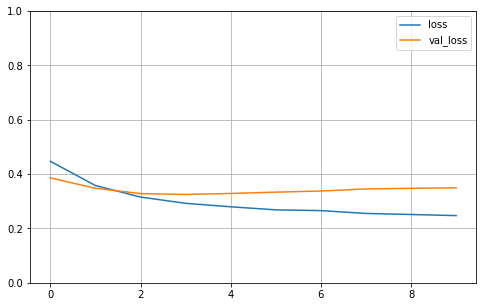

In [359]:
# Check if it's a good fit model by learning curve
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [357]:
history.history.keys()

dict_keys(['loss', 'val_loss'])